In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
class WasteDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Dataset for Organic vs Recyclable waste classification
        
        Args:
            root_dir: Path to DATASET folder (/kaggle/input/waste-classification-data/DATASET)
            split: 'train' or 'test'
            transform: Image transformations
        """
        self.root_dir = root_dir
        self.split = split.upper()
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Class mapping: O=0 (Organic), R=1 (Recyclable)
        self.class_to_idx = {'O': 0, 'R': 1}
        self.class_names = ['Organic', 'Recyclable']
        
        # Build dataset
        split_path = os.path.join(root_dir, self.split)
        
        for class_folder in ['O', 'R']:
            class_path = os.path.join(split_path, class_folder)
            
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
                
                for image_file in image_files:
                    self.images.append(os.path.join(class_path, image_file))
                    self.labels.append(self.class_to_idx[class_folder])
        
        print(f"{split.capitalize()} dataset: {len(self.images)} images")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
IMG_SIZE = 224

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
data_path = '/kaggle/input/waste-classification-data/DATASET'

In [10]:
train_dataset = WasteDataset(data_path, split='train', transform=train_transform)
test_dataset = WasteDataset(data_path, split='test', transform=test_transform)

Train dataset: 22564 images
Test dataset: 2513 images


In [11]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 706
Test batches: 79


In [12]:
class WasteCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(WasteCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
            
            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
        )
        
        # Calculate the size after convolutions
        # For 224x224 input: 224->112->56->28->14
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
model = WasteCNN(num_classes=2).to(device)

In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 6,878,338


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [16]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [17]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [18]:
def test_epoch(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy, all_preds, all_labels

In [19]:
epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
best_test_acc = 0.0

print("Starting training...")
print("=" * 60)

Starting training...


In [20]:
for epoch in range(epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Testing
    test_loss, test_acc, _, _ = test_epoch(model, test_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(test_loss)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_waste_classifier.pth')
    
    # Print progress
    print(f"Epoch [{epoch+1:2d}/{epochs}]")
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"Test  - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%")
    print(f"Best Test Acc: {best_test_acc:.2f}%")
    print("-" * 60)aqa

Epoch [ 1/10]
Train - Loss: 0.4957, Acc: 78.55%
Test  - Loss: 0.3819, Acc: 86.75%
Best Test Acc: 86.75%
------------------------------------------------------------
Epoch [ 2/10]
Train - Loss: 0.4566, Acc: 80.13%
Test  - Loss: 0.3903, Acc: 85.56%
Best Test Acc: 86.75%
------------------------------------------------------------
Epoch [ 3/10]
Train - Loss: 0.4487, Acc: 80.92%
Test  - Loss: 0.3456, Acc: 85.52%
Best Test Acc: 86.75%
------------------------------------------------------------
Epoch [ 4/10]
Train - Loss: 0.4404, Acc: 81.41%
Test  - Loss: 0.4107, Acc: 82.21%
Best Test Acc: 86.75%
------------------------------------------------------------
Epoch [ 5/10]
Train - Loss: 0.4345, Acc: 81.72%
Test  - Loss: 0.3817, Acc: 82.41%
Best Test Acc: 86.75%
------------------------------------------------------------
Epoch [ 6/10]
Train - Loss: 0.4260, Acc: 82.21%
Test  - Loss: 0.3053, Acc: 86.51%
Best Test Acc: 86.75%
------------------------------------------------------------
Epoch [ 7/

In [21]:
print(f"\nTraining completed!")
print(f"Best test accuracy: {best_test_acc:.2f}%")


Training completed!
Best test accuracy: 89.38%


In [22]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

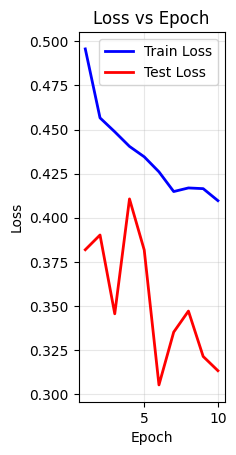

In [23]:
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(range(1, epochs+1), test_losses, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

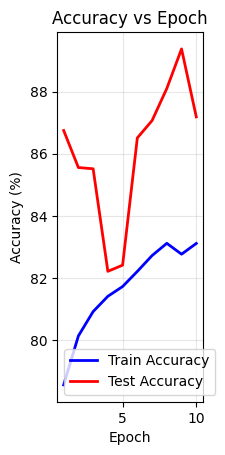

In [24]:
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
plt.plot(range(1, epochs+1), test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

In [25]:
model.load_state_dict(torch.load('best_waste_classifier.pth'))
_, _, final_preds, final_labels = test_epoch(model, test_loader, criterion, device)

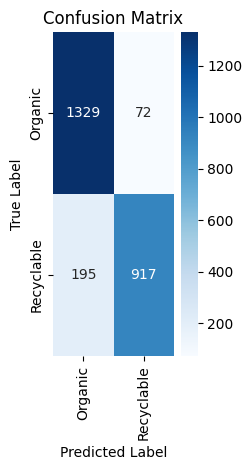

In [26]:
plt.subplot(1, 3, 3)
cm = confusion_matrix(final_labels, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Organic', 'Recyclable'], 
            yticklabels=['Organic', 'Recyclable'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [27]:
print("\nDetailed Classification Report:")
print("=" * 50)
class_names = ['Organic', 'Recyclable']
report = classification_report(final_labels, final_preds, 
                             target_names=class_names, digits=4)
print(report)


Detailed Classification Report:
              precision    recall  f1-score   support

     Organic     0.8720    0.9486    0.9087      1401
  Recyclable     0.9272    0.8246    0.8729      1112

    accuracy                         0.8938      2513
   macro avg     0.8996    0.8866    0.8908      2513
weighted avg     0.8965    0.8938    0.8929      2513

